In [150]:
import os
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import seaborn as sns
import tensorflow as tf
import numpy as np
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

In [151]:
data = pd.read_csv("dat_mice.csv",encoding = 'euc-kr')

In [152]:
dataset=data

#6.25 기간 제거
data1=dataset[:15434]
data2=dataset[16054:]

dataset=pd.concat([data1,data2],ignore_index=True)

In [153]:
features_considered =['tempHigh','tempAvg', 'VPAvg','RHAvg','groundTempAvg', 'temp_5', 'temp1_5', 'windMax','date']

In [154]:
features=dataset[features_considered]
features.head()

,tempHigh,tempAvg,VPAvg,RHAvg,groundTempAvg,temp_5,temp1_5,windMax,date
0,20.7,13.5,9.6,67.7,14.3,16.2,12.6,3.7,1907-10-01
1,22.0,16.2,13.2,74.7,17.8,16.4,17.8,2.2,1907-10-02
2,21.3,16.2,14.5,82.0,20.5,21.6,21.6,6.2,1907-10-03
3,22.0,16.5,14.8,82.3,19.9,19.6,16.5,1.7,1907-10-04
4,25.4,17.6,13.5,72.0,20.3,21.8,21.1,2.4,1907-10-05


In [155]:
def outliar(data): #이상치 제거 파악
    q1,q3=np.percentile(data,[25,75])
    iqr =q3-q1
    lower=q1-(iqr*1.5)
    upper=q3+(iqr*1.5)
    return np.where((data>upper)|(data<lower))

In [156]:
delout=(1541,1592,3363,4260,7972,9204,10631,16764,20230,26981,29234,30156,30700,42364)

In [157]:
finout=[]
for i in features.index:
    if i not in delout:
        finout.append(i)

In [158]:
feature2=features.loc[finout]
feature2=feature2.reset_index(drop=True)
features=feature2

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

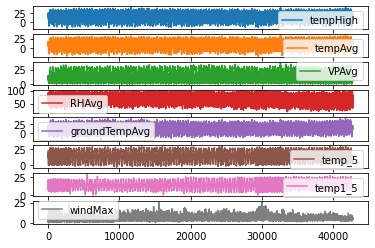

In [159]:
features.plot(subplots=True)

In [160]:
import datetime #날짜를 1년중 몇일인지로 변환
idx=0
for loc in features['date'] :
    indate=loc
    changeday=datetime.datetime.strptime(indate,"%Y-%m-%d").date()
    thisday =changeday.strftime('%j')
    features['date'][idx]=int(thisday)
    idx += 1


C:\Users\lgm2713\anaconda3\envs\test\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [161]:

features.head()


,tempHigh,tempAvg,VPAvg,RHAvg,groundTempAvg,temp_5,temp1_5,windMax,date
0,20.7,13.5,9.6,67.7,14.3,16.2,12.6,3.7,274
1,22.0,16.2,13.2,74.7,17.8,16.4,17.8,2.2,275
2,21.3,16.2,14.5,82.0,20.5,21.6,21.6,6.2,276
3,22.0,16.5,14.8,82.3,19.9,19.6,16.5,1.7,277
4,25.4,17.6,13.5,72.0,20.3,21.8,21.1,2.4,278


In [162]:
target_names = ['tempHigh','tempAvg', 'VPAvg','RHAvg','groundTempAvg', 'temp_5', 'temp1_5', 'windMax'] #예측할 변수

In [163]:
x_data = features.values[0:-1]

In [164]:
print(type(x_data))
print("Shape:", x_data.shape)

<class 'numpy.ndarray'>
Shape: (42748, 9)


In [165]:
df_targets = features[target_names].shift(-1) #1일 후 예측

In [166]:
y_data = df_targets.values[:-1]

In [167]:
print(type(y_data))
print("Shape:", y_data.shape)

<class 'numpy.ndarray'>
Shape: (42748, 8)


In [168]:
train_split = 0.8           #train : test 8:2
num_data = len(x_data)
num_train = int(train_split * num_data)
num_test = num_data - num_train

In [169]:
x_train = x_data[0:num_train]
x_test = x_data[num_train:]
y_train = y_data[0:num_train]
y_test = y_data[num_train:]

In [170]:
y_test

array([[-2.9, -6.6,  1.3, ...,  7.7, 13.6,  7.7],
       [-3.5, -7. ,  1.2, ...,  7.1, 13.6,  4.7],
       [ 5.2, -0.9,  2.8, ...,  6.6, 13.5,  2.2],
       ...,
       [18.2, 14.5, 10.3, ..., 15.7, 13.3,  4.8],
       [20.1, 14.6,  8.6, ..., 15.6, 13.4,  6.4],
       [14.6, 11.3, 10.8, ..., 15.3, 13.6,  5.2]])

In [171]:
num_x_signals = x_data.shape[1]
num_y_signals = y_data.shape[1]

In [ ]:
print("Min:", np.min(x_train))
print("Max:", np.max(x_train))

In [173]:
x_scaler = MinMaxScaler()        #0과 1사이로 재조정
x_train_scaled = x_scaler.fit_transform(x_train)
print("Min:", np.min(x_train_scaled))
print("Max:", np.max(x_train_scaled))
x_test_scaled = x_scaler.transform(x_test)
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)
print(x_train_scaled.shape)
print(y_train_scaled.shape)

Min: 0.0
Max: 1.0000000000000002
(34198, 9)
(34198, 8)


In [174]:
def batch_generator(batch_size, sequence_length):#특정 기간만큼의 데이터를 뭉텅이로 랜덤 제공
    while True:
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        for i in range(batch_size):
            idx = np.random.randint(num_train - sequence_length)
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        yield (x_batch, y_batch)
 

In [175]:
batch_size = 1024
sequence_length = 30*2

In [176]:
generator = batch_generator(batch_size=batch_size,sequence_length=sequence_length)

In [177]:
x_batch, y_batch = next(generator)

In [178]:
print(x_batch.shape)
print(y_batch.shape)

(1024, 60, 9)
(1024, 60, 8)


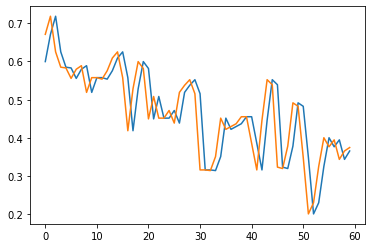

In [179]:
batch = 0 
signal = 0 
seq = x_batch[batch, :, signal]
plt.plot(seq)
seq = y_batch[batch, :, signal]
plt.plot(seq)

In [180]:
validation_data = (np.expand_dims(x_test_scaled, axis=0),np.expand_dims(y_test_scaled, axis=0)) #테스트셋을 검증셋 겸용으로 사용

In [224]:
model = Sequential()
model.add(tf.keras.layers.LSTM(units=512,return_sequences=True,input_shape=(None, num_x_signals,)))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.LSTM(units=256,return_sequences=True,input_shape=(None, num_x_signals,)))
model.add(tf.keras.layers.Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(num_y_signals, activation='sigmoid'))

In [225]:
warmup_steps = 50
def loss_mse_warmup(y_true, y_pred): #초반 값 불안정으로 해당부분 미반영하고 진행

    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    loss = tf.losses.MSE(y_true_slice,y_pred_slice)

    loss_mean = tf.reduce_mean(loss)
    return loss_mean

In [226]:
model.compile(loss=loss_mse_warmup, optimizer='Adam')
model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, None, 512)         1069056   
_________________________________________________________________
dropout_6 (Dropout)          (None, None, 512)         0         
_________________________________________________________________
lstm_7 (LSTM)                (None, None, 256)         787456    
_________________________________________________________________
dropout_7 (Dropout)          (None, None, 256)         0         
_________________________________________________________________
dense_4 (Dense)              (None, None, 64)          16448     
_________________________________________________________________
dense_5 (Dense)              (None, None, 8)           520       
Total params: 1,873,480
Trainable params: 1,873,480
Non-trainable params: 0
____________________________________________

In [228]:
"""
학습 후 성능 향상 시 저장
성능 향상 없을시 학습 중지
TensorBoard 로그 작성
"""
path_checkpoint = 'checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,monitor='val_loss',verbose=1,
                                      save_weights_only=True,save_best_only=True)
callback_early_stopping = EarlyStopping(monitor='val_loss',patience=5, verbose=1)
callback_tensorboard = TensorBoard(log_dir='./modellogs/',histogram_freq=0,write_graph=False)
callbacks = [callback_early_stopping,callback_checkpoint,callback_tensorboard]

In [ ]:

model.fit(generator,epochs=50,steps_per_epoch=200,validation_data=validation_data,callbacks=callbacks)

Epoch 1/50
200/200 [==============================] - 25s 114ms/step - loss: 0.0104 - val_loss: 0.0063

Epoch 00001: val_loss improved from inf to 0.00628, saving model to checkpoint.keras
Epoch 2/50
200/200 [==============================] - 24s 120ms/step - loss: 0.0066 - val_loss: 0.0058

Epoch 00002: val_loss improved from 0.00628 to 0.00583, saving model to checkpoint.keras
Epoch 3/50
200/200 [==============================] - 23s 113ms/step - loss: 0.0059 - val_loss: 0.0046

Epoch 00003: val_loss improved from 0.00583 to 0.00464, saving model to checkpoint.keras
Epoch 4/50
200/200 [==============================] - 22s 112ms/step - loss: 0.0052 - val_loss: 0.0041

Epoch 00004: val_loss improved from 0.00464 to 0.00409, saving model to checkpoint.keras
Epoch 5/50
 76/200 [==========>...................] - ETA: 13s - loss: 0.0050

In [212]:

try:
    model.load_weights(path_checkpoint) #가장 최근에 저장된 모델 불러오기
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

In [213]:
result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),y=np.expand_dims(y_test_scaled, axis=0))

1/1 [==============================] - 0s 385ms/step - loss: 0.0037


In [214]:
print("loss (test-set):", result)

loss (test-set): 0.003709343494847417


In [215]:
def plot_compbypre(start_idx, length=100): #200일의 데이터만 제공하고 그 후는 예측한 값을 바탕으로 다시 예측하여 표현하는 함수

    x = x_test_scaled
    y_true = y_test        
    end_idx = start_idx + length
    x = x[start_idx-200:start_idx]
    y_true = y_true[start_idx:end_idx]

    x = np.expand_dims(x, axis=0)
    xdate=x_scaler.inverse_transform(x[0])
    xdate=xdate[-1][8]
    
    y_pred = model.predict(x)
    qq=y_scaler.inverse_transform(np.expand_dims(y_pred[0][-1], axis=0))
    qq=np.expand_dims(np.append(qq[0],xdate+1), axis=0)
    qq=x_scaler.transform(qq)
    x=x[0]
    x=np.append(x,qq,axis=0)
    x=np.expand_dims(x,axis=0)

    for j in range(length):
        pred = model.predict(x)
        if xdate>364:
            xdate=1
        else:
            xdate=xdate+1
        qq=y_scaler.inverse_transform(np.expand_dims(pred[0][-1], axis=0))
        qq=np.expand_dims(np.append(qq[0],xdate), axis=0)
        qq=x_scaler.transform(qq)
        x=x[0]
        x=np.append(x,qq,axis=0)
        x=np.expand_dims(x,axis=0)
    y_pred=x[0][200:]
    y_pred=np.delete(y_pred,8,axis=1)
    y_pred_rescaled = y_scaler.inverse_transform(y_pred)
    signal_pred = y_pred_rescaled[:, 0]
    signal_true = y_true[:, 0] 
    plt.figure(figsize=(15,5))
    plt.plot(signal_true, label='true')
    plt.plot(signal_pred, label='pred')
    plt.ylabel(target_names[0])
    plt.legend()
    plt.show()
    return y_pred_rescaled[:, 0], y_true[:, 0] 
        


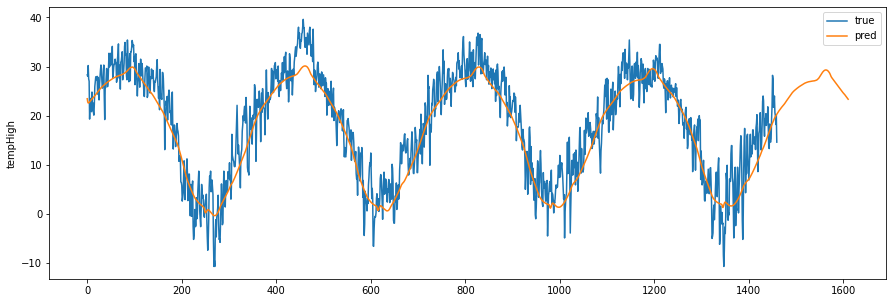

In [216]:
#여기까지
pdata,rdata=plot_compbypre(7090, length=1610)#150

In [ ]:
dfpdata=pd.DataFrame(pdata)
dfrdata=pd.DataFrame(rdata)

In [ ]:
"""
그래프를 따로 그릴떄 날짜별수를 별도로 생성하기 위해 넣은 부분.
본문과 큰 상관X
"""
from datetime import datetime, timedelta

def date_range(start):
    start = datetime.strptime(start, "%Y-%m-%d")

    dates = [(start + timedelta(days=i)) for i in range(1460)]
    return dates
def date_range2(start):
    start = datetime.strptime(start, "%Y-%m-%d")

    dates = [(start + timedelta(days=i)) for i in range(1611)]
    return dates
dates = date_range("2017-04-17")
dates2 =date_range2("2017-04-17")

In [ ]:
"""
예측했던 데이터를 동적그래프로 다시 그려 html로 나타내는 부분
"""
from bokeh.models import ColumnDataSource,Legend
from bokeh.plotting import output_notebook, figure, show,output_file

TOOLS = "pan,wheel_zoom,box_zoom,reset,save,box_select,hover"
#output_notebook()
output_file("maybefinal.html")
p = figure(x_axis_type='datetime',plot_width=900, plot_height= 300)

r1=p.line(dates2,33,line_width = 1,line_dash=[5,3], color = '#e88ec5')
r2=p.line(dates, dfrdata[0],  line_width = 1, color = '#ed907e')
r3=p.line(dates2, dfpdata[0],  line_width = 2, color = '#92a5b6')

legend = Legend(items=[
    ('실제',   [r2]),
    ('예측', [r3]),
    ('폭염', [r1])
], location=(0, -30))

p.add_layout(legend, 'right')

show(p)

In [219]:
def plot_comparison(start_idx, length=100, train=True): #주어진 데이터 기간의 +1 날짜를 예측하여 표현하는 함수.

    if train:
        x = x_train_scaled
        y_true = y_train
    else:
        x = x_test_scaled
        y_true = y_test

    end_idx = start_idx + length


    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    print(x)

    x = np.expand_dims(x, axis=0)
    y_pred = model.predict(x)
    print(len(x[0]))

    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    print(y_pred_rescaled )

 
    for signal in range(len(target_names)):
        signal_pred = y_pred_rescaled[:, signal]
        signal_true = y_true[:, signal]
        plt.figure(figsize=(15,5))
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        plt.ylabel(target_names[signal])
        plt.legend()
        plt.show()

[[0.80621572 0.73764259 0.33146067 ... 0.43205575 0.19230769 0.3260274 ]
 [0.81535649 0.75285171 0.28932584 ... 0.43554007 0.18076923 0.32876712]
 [0.80987203 0.76425856 0.25561798 ... 0.43902439 0.17307692 0.33150685]
 ...
 [0.66361974 0.6634981  0.28089888 ... 0.44250871 0.19230769 0.31780822]
 [0.63071298 0.64638783 0.27247191 ... 0.44947735 0.18461538 0.32054795]
 [0.6654479  0.64828897 0.2247191  ... 0.45296167 0.24615385 0.32328767]]
1460
[[24.486725  17.48893   22.235968  ... 18.61919   14.510707   9.550834 ]
 [28.64011   21.453936  22.546263  ... 21.308994  14.478053   8.928894 ]
 [29.285713  22.567892  21.357487  ... 22.25552   14.564051   8.680393 ]
 ...
 [20.70252   15.440111  10.183066  ... 15.286953  13.0531645  5.3874254]
 [20.330694  15.016693   9.66551   ... 15.107235  13.117484   5.379812 ]
 [20.869516  15.074747   8.795861  ... 15.1332445 12.971266   5.5821543]]


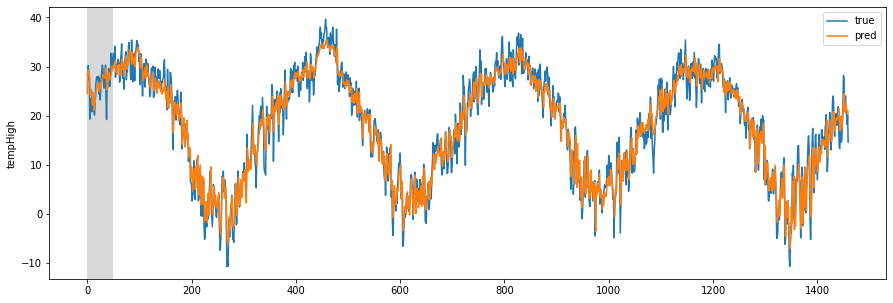

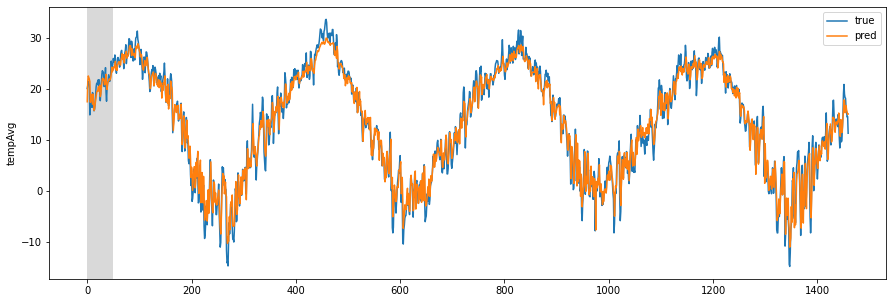

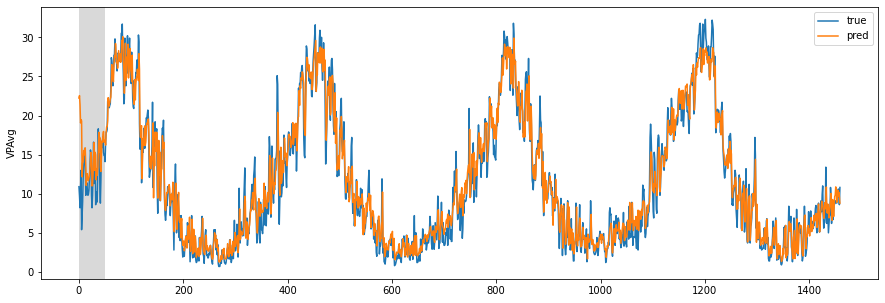

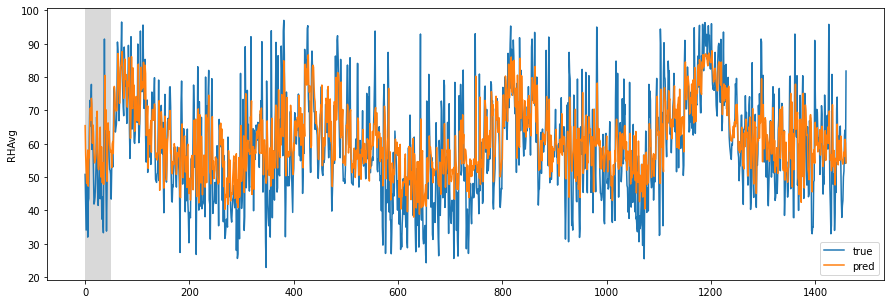

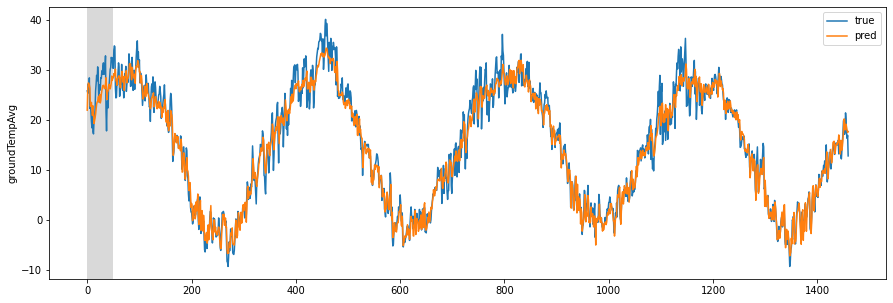

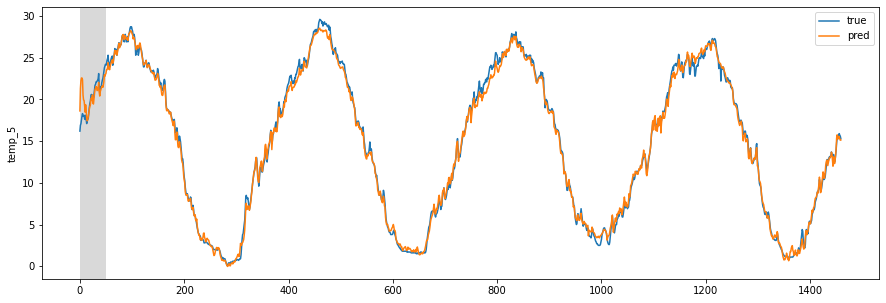

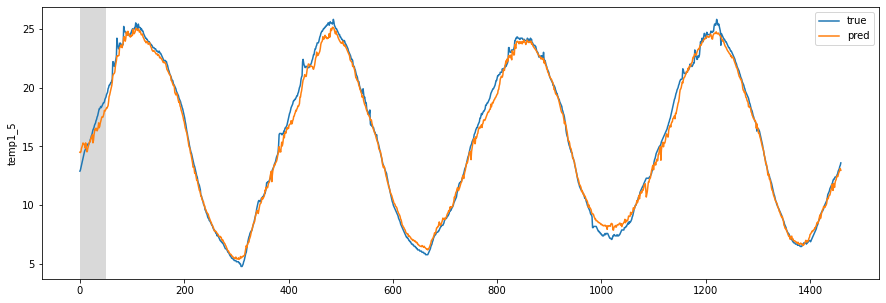

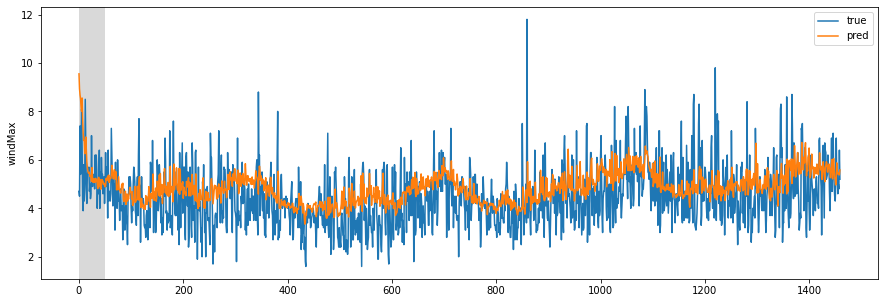

In [223]:
plot_comparison(start_idx=7090, length=1490, train=False)